In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

2024-12-17 01:21:14.985392: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 01:21:15.182367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734409275.255161   28554 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734409275.274348   28554 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 01:21:15.425352: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Caminho para as pastas originais
dataset_dir = 'fire_dataset'  # Substitua pelo caminho correto

# Caminhos para criar as pastas de treino e teste
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Criação das pastas de treino e teste
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Subpastas para cada classe (fire e not_fire)
train_fire_dir = os.path.join(train_dir, 'fire')
train_not_fire_dir = os.path.join(train_dir, 'not_fire')
test_fire_dir = os.path.join(test_dir, 'fire')
test_not_fire_dir = os.path.join(test_dir, 'not_fire')

# Criando as subpastas, se não existirem
os.makedirs(train_fire_dir, exist_ok=True)
os.makedirs(train_not_fire_dir, exist_ok=True)
os.makedirs(test_fire_dir, exist_ok=True)
os.makedirs(test_not_fire_dir, exist_ok=True)


In [3]:
# Função para mover as imagens para as pastas de treino e teste
def move_images(source_dir, train_dir, test_dir, test_size=0.2):
    # Obtendo os caminhos dos arquivos
    images = [f for f in os.listdir(source_dir) if f.endswith('.jpg') or f.endswith('.png')]
    
    # Separando os dados em treinamento e teste
    train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
    
    # Movendo as imagens para as pastas correspondentes
    for img in train_images:
        shutil.move(os.path.join(source_dir, img), os.path.join(train_dir, img))
    
    for img in test_images:
        shutil.move(os.path.join(source_dir, img), os.path.join(test_dir, img))

# Movendo as imagens da pasta 'fire' e 'not_fire'
move_images(os.path.join(dataset_dir, 'fire'), train_fire_dir, test_fire_dir)
move_images(os.path.join(dataset_dir, 'not_fire'), train_not_fire_dir, test_not_fire_dir)


In [ ]:
# Gerador de dados com aumento para o conjunto de treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Gerador de dados sem aumento para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

# Gerador de dados para o conjunto de treinamento
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Caminho para a pasta de treinamento
    target_size=(224, 224),  
    batch_size=32,  
    class_mode='binary'  # Tipo de classificação binária: fogo ou não fogo
)

# Gerador de dados para o conjunto de teste
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Caminho para a pasta de teste
    target_size=(224, 224),  
    batch_size=32,  
    class_mode='binary',  # Tipo de classificação binária: fogo ou não fogo
    shuffle=False  # Não embaralhar para correlacionar com as previsões
)

Found 7203 images belonging to 2 classes.
Found 1802 images belonging to 2 classes.


In [ ]:
# Carregando o modelo base ResNet50
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelando as camadas do modelo base
base_model.trainable = False

# Criando o modelo com camadas customizadas
model = tf.keras.models.Sequential([
    base_model,  #RESNET
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(1024, activation='relu'),  
    tf.keras.layers.Dense(1, activation='sigmoid')  # Saída binária: 0 (sem fogo), 1 (com fogo)
])

# Compilando o modelo
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Treinando o modelo
history = model.fit(
    train_generator,  # Dados de treinamento
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  
    epochs=50, 
    validation_data=test_generator,  # Dados de validação
    validation_steps=test_generator.samples // test_generator.batch_size  
)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 71s 290ms/step - accuracy: 0.6456 - loss: 0.6416 - val_accuracy: 0.6730 - val_loss: 0.5927
Epoch 2/50
  1/225 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5938 - loss: 0.6503

/home/thomaz/proj3/MLET_PROJ3/env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5938 - loss: 0.6503 - val_accuracy: 0.6735 - val_loss: 0.5925
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 62s 276ms/step - accuracy: 0.6968 - loss: 0.5841 - val_accuracy: 0.7305 - val_loss: 0.5651
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.6250 - loss: 0.6510 - val_accuracy: 0.7310 - val_loss: 0.5652
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 64s 285ms/step - accuracy: 0.7322 - loss: 0.5584 - val_accuracy: 0.7494 - val_loss: 0.5492
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8750 - loss: 0.4223 - val_accuracy: 0.7489 - val_loss: 0.5488
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 91s 364ms/step - accuracy: 0.7384 - loss: 0.5423 - val_accuracy: 0.7467 - val_loss: 0.5338
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7500 - loss: 0.5507 - val_accuracy: 0.7455 - val_loss: 0.5338
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 89s 383ms/step - accuracy: 0.7434 - loss: 0.5306 - val_accurac

In [18]:
# Avaliando o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Acurácia no conjunto de teste: {test_acc:.4f}')

# Gerando previsões no conjunto de teste
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred)  # Arredondando para 0 ou 1

# Relatório de classificação (precisão, recall, F1-score)
print(classification_report(test_generator.classes, y_pred))

57/57 - 8s - 144ms/step - accuracy: 0.7919 - loss: 0.4945
Acurácia no conjunto de teste: 0.7919
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1165
           1       0.70      0.71      0.71       637

    accuracy                           0.79      1802
   macro avg       0.77      0.77      0.77      1802
weighted avg       0.79      0.79      0.79      1802



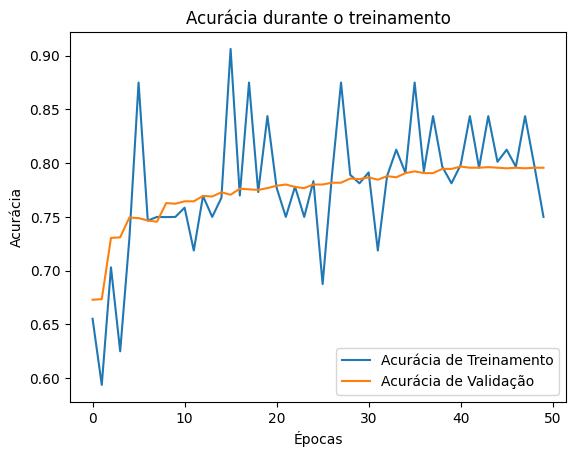

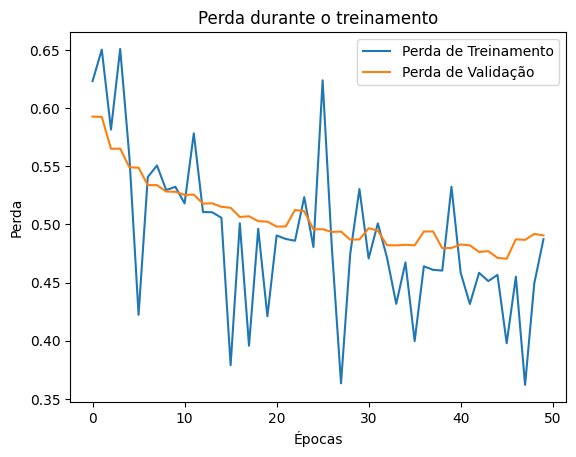

In [19]:
# Plotando a acurácia durante o treinamento
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Plotando a perda durante o treinamento
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [20]:
# Salvando o modelo treinado
model.save('modelo_fogo.h5')